# Recent COVID-19 events have placed an emphasis on "flattening the curve" so that the number of cases does not exceed the capacity to handle those cases

## The purpose of this is to provide a time-series forecast model to predict if the number of positives a country/territory will receive within the next number of days will increase or decrease

# Models used:

> AutoRegressive Integrated Moving Average (ARIMA) used as a baseline and for feature selection, referenced a guide from Jason Brownlee: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

> Multiple classification machine learning algorithms from scikit learn to determine if the number will go up or down

# Initialize some things

In [1]:
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from math import log
from tabulate import tabulate
import time
import pickle
import warnings
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree.export import export_text
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from statistics import stdev as std
from IPython.display import display, clear_output
import random
from sklearn.model_selection import GridSearchCV

In [2]:
class Timer:
    def __init__(self):
        self.start = time.time()
        
    def restart(self):
        self.start = time.time()
        
    def get_new_time(self):
        value = time.time() - self.start
        self.restart()
        return value

In [3]:
days_missing = 2 # Threshold for the maximum consequitive days a country can be missing data to accept data
days_total = 20 # Threshold for the minimum number of days required from a country to accept data
cases_max = 20 # Threshold for maximum number of cases recorded in a day to accept data

run_autocorrelation = True # runs autocorrelation to look at correlated number of lags in time series data

run_ARIMA = False # runs ARIMA to explore data, this takes 2-5 hours but can be parallelized to speed up
outpath_ARIMA = 'ARIMA_results' # path to output pickle file of results from ARIMA test
read_ARIMA_results = True # read ARIMA results from previous runs
input_ARIMA = ['ARIMA_results', 'ARIMA_results_par'] # paths to input pickle files to read results from past ARIMA tests

test_split = .10 # percent to pull out for testing at end
resample = True # Resamples train and test data, if false will read from file otherwise if true will write to file
output_sample = 'MLA_sample'
input_sample = 'MLA_sample'

run_class = True # runs MLA classification tests
output_class = 'MLA_classification_results' # path to otuput pickle file with results from classification MLA tests
read_class_results = False # reads MLA classification results from previous runs
input_class = ['MLA_classification_results'] # paths to input pickle files to read results from past class MLA tests

run_regerss = True # runs MLA regression tests
output_regress = 'MLA_regression_results' # path to otuput pickle file with results from regression MLA tests
read_regress_results = False # reads MLA regression results from previous runs
input_regress = ['MLA_regression_results'] # paths to input pickle files to read results from past class MLA tests

# Read data

In [4]:
# read raw covid19 cases data 
# https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
covid19_cases = pd.read_csv('COVID-19_cases_20200320.csv')

# remove all attributes except country and number of cases by date
covid19_cases = covid19_cases[['DateRep', 'Cases', 'Countries and territories']]
covid19_cases.columns = ['Date', 'Cases', 'Country']
covid19_cases['Date'] = pd.to_datetime(covid19_cases.Date)
covid19_cases.head()

# organize by day number
data = covid19_cases.sort_values(by=['Country','Date'])

# fix something so the cases an population .csv file names match up by country name
data['Country'] = data['Country'].str.replace('_', ' ')
data['Country'] = data['Country'].str.replace('CANADA', 'Canada') # Canada was entered in all-caps?
data = data.loc[data['Country'] != 'Cote dIvoire']
data = data.loc[data['Country'] != 'Kosovo']
data = data.loc[data['Country'] != 'Cases on an international conveyance Japan']
data.head()

,Date,Cases,Country
70,2019-12-31,0,Afghanistan
69,2020-01-01,0,Afghanistan
68,2020-01-02,0,Afghanistan
67,2020-01-03,0,Afghanistan
66,2020-01-04,0,Afghanistan


# Mungle and Visualize Data

In [5]:
def plot5(data, countries, xlabel, ylabel):
    lastCut = 0
    for i in range(0, len(countries), 5):
        lastCountry = ''
        nCountries = 0
        thisCut = lastCut
        for i in range(lastCut, len(data), 1):
            thisCountry = str(data.at[i,'Country'])
            if thisCountry not in lastCountry or i == len(data) - 1:
                nCountries += 1
            lastCountry = thisCountry
            if nCountries > 5:
                break
            thisCut += 1
        fig, ax = plt.subplots(figsize=(15,7))
        data.iloc[lastCut:thisCut].groupby(['Day', 'Country']).sum()['Cases'].unstack().plot(ax=ax)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        lastCut = thisCut

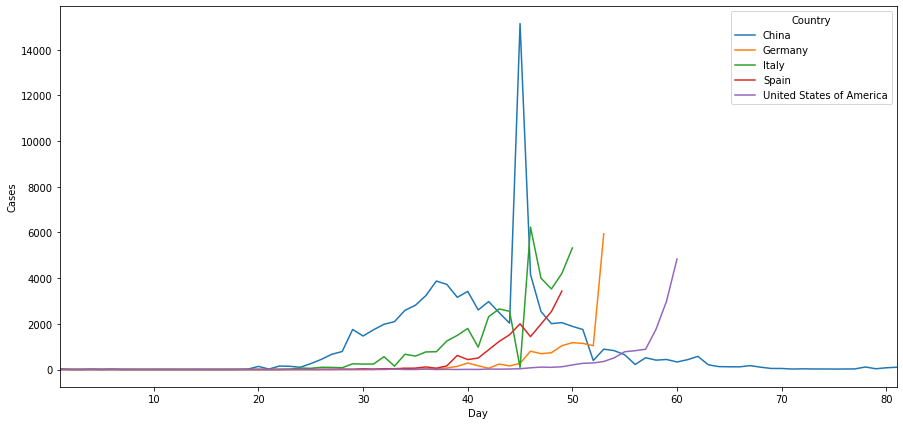

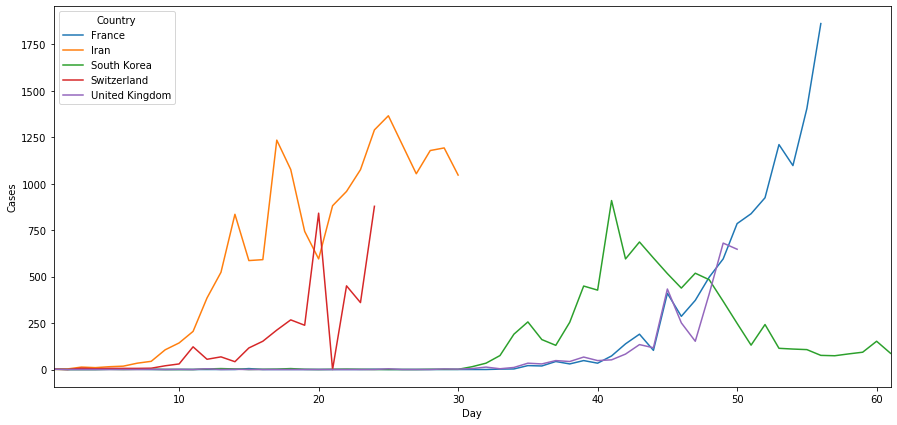

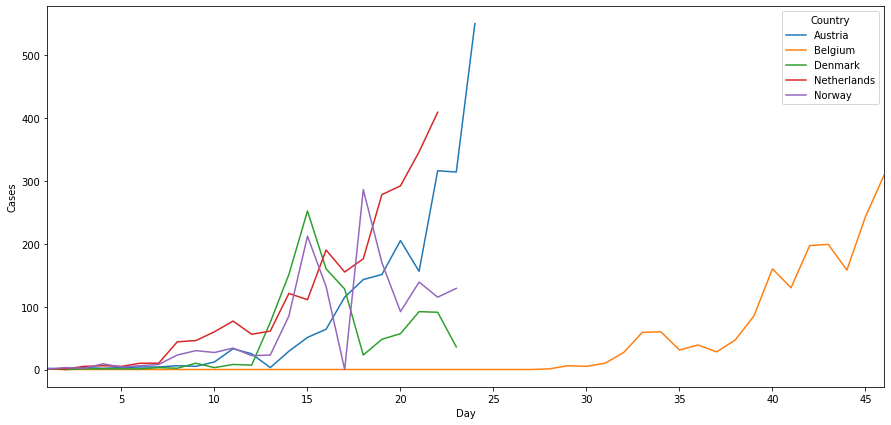

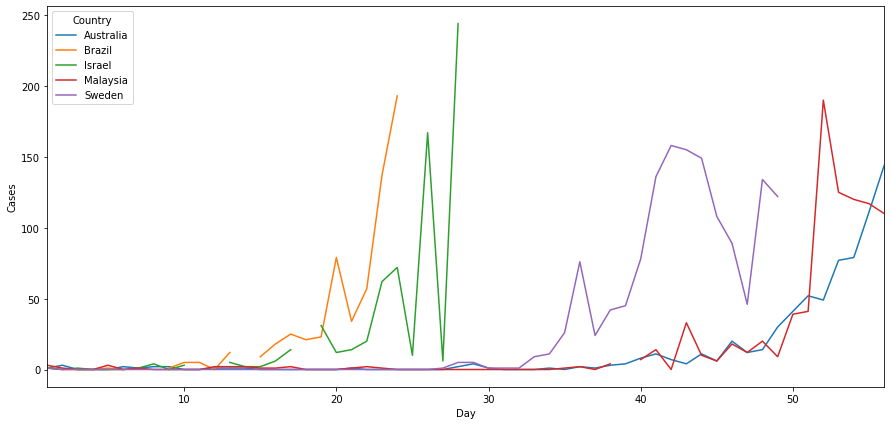

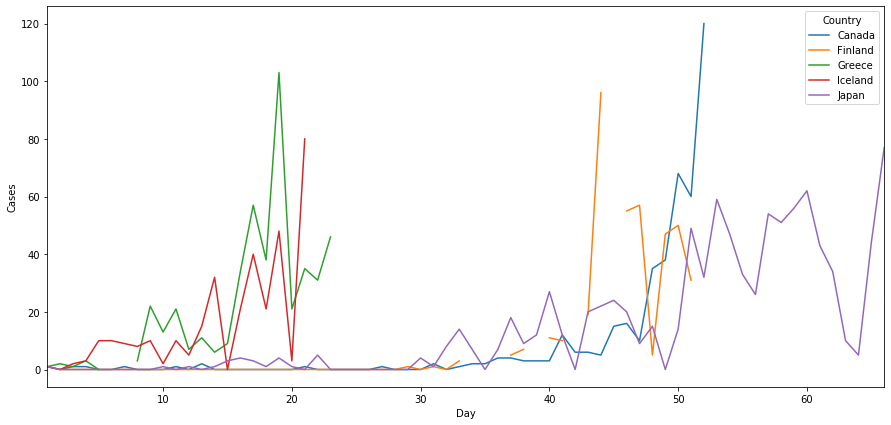

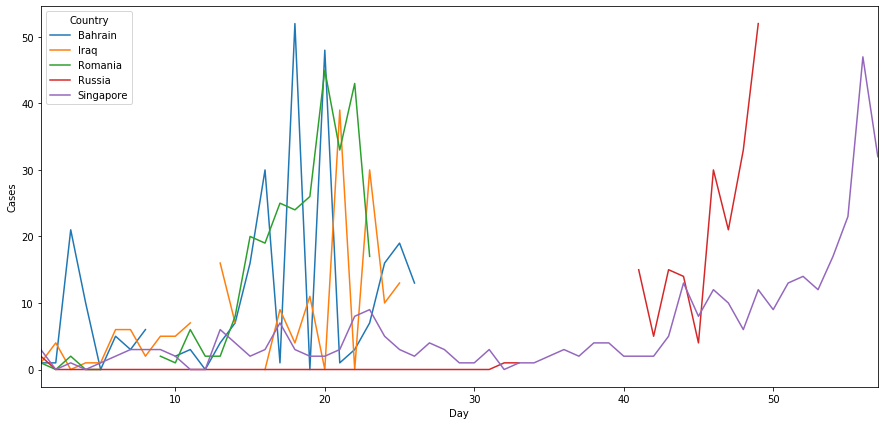

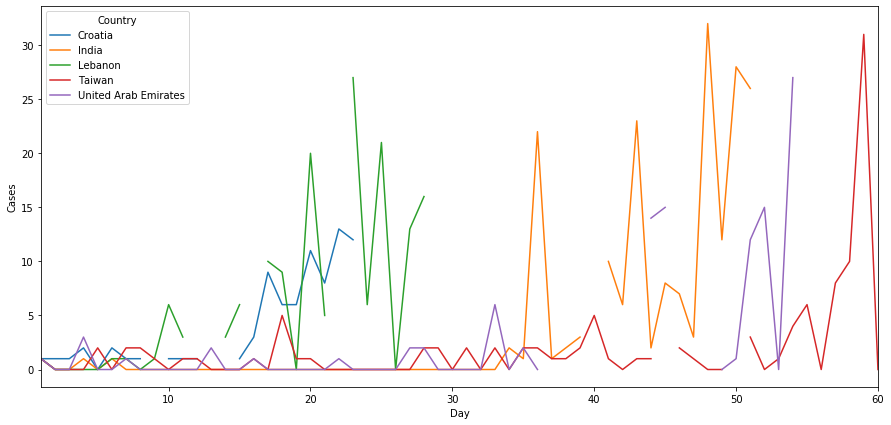

In [6]:
# re-rank date by day# starting with first case
    # remove country if more than days_missing in a row day is missing
    # only count if 10 days exist
    # sort by max number of cases
reranked = []
tosort = {}
lastCountry = ''
lastDate = ''
dayNum = 1
firstCase = False
temp = []
skip = False
maxCases = 0
maxes = []
for index, row in data.iterrows():
    thisDate = row[0]
    cases = row[1]
    country = row[2]
    
    if country not in lastCountry:
        if not skip and len(temp) >= days_total and maxCases > cases_max:
            tosort[lastCountry] = [temp, maxCases]
            maxes.append(maxCases)
        temp = []
        skip = False
        firstCase = False
        dayNum = 1
        maxCases = 0
        
    if cases > 0 and not firstCase:
        lastDate = thisDate
        firstCase = True
    
    if firstCase:
        if (thisDate - lastDate).days > days_missing + 1:
            skip = True
        maxCases = max(cases, maxCases)
        dayNum += (thisDate - lastDate).days
        if dayNum < 0:
            break
        temp.append([dayNum, cases, country])
    
    lastDate = thisDate
    lastCountry = country
if not skip and len(temp) >= days_total and maxCases > cases_max:
    tosort[lastCountry] = [temp, maxCases]
    maxes.append(maxCases)
    
# sort
while len(maxes) > 0:
    thisMax = max(maxes)
    pops = []
    for country in tosort:
        rows = tosort[country][0]
        maxCases = tosort[country][1]
        if thisMax == maxCases:
            reranked = reranked + rows
            pops.append(country)
    for country in pops:        
        tosort.pop(country)
    maxes = [x for x in maxes if x < thisMax]
    
data = pd.DataFrame(reranked, columns=['Day', 'Cases', 'Country'])
countries = data['Country'].unique()

# plot 5 at a time
plot5(data, countries, 'Day', 'Cases')

In [7]:
# split into dictionary and remove 0s
covid19 = {}
for i in range(len(data)):
    country = data.at[i,'Country'] 
    if country not in covid19:
        covid19[country] = []
    if data.at[i,'Cases'] > 0:
        covid19[country].append(data.at[i,'Cases'])

# FEATURE SELECTION

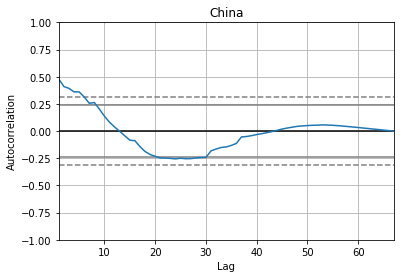

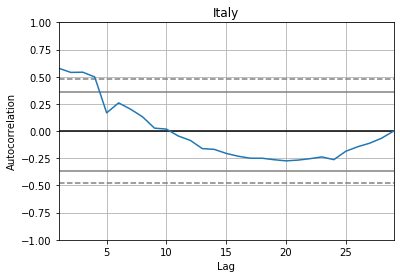

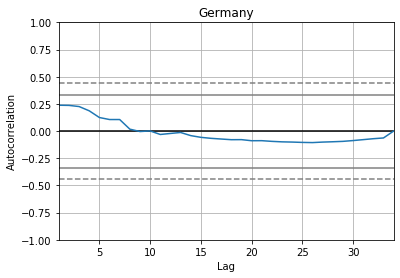

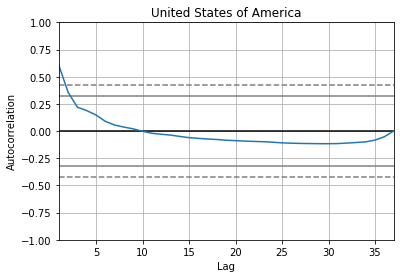

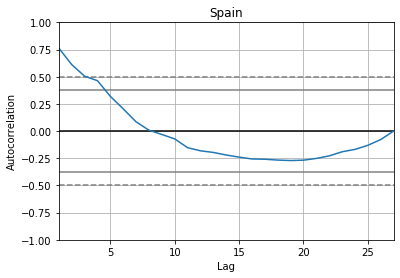

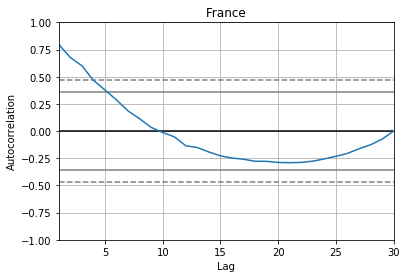

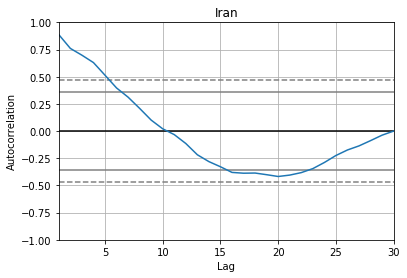

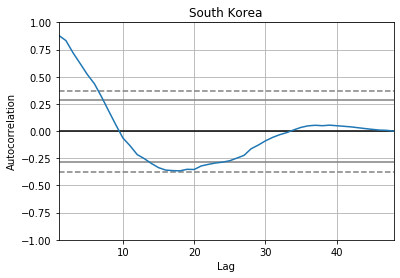

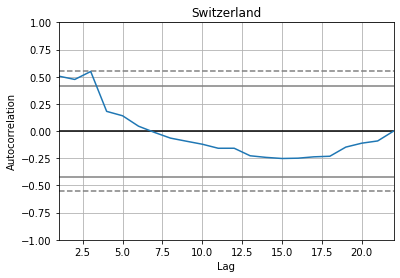

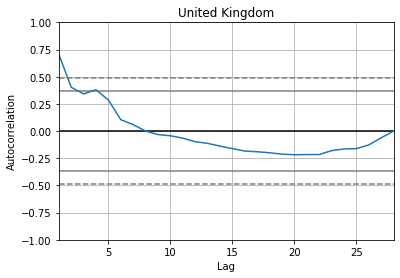

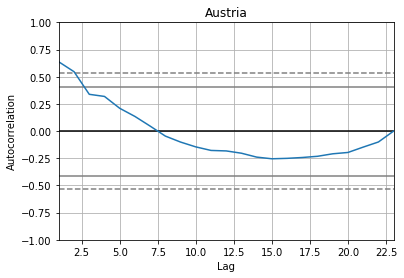

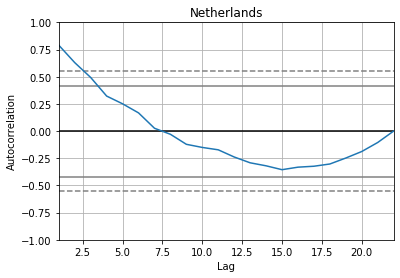

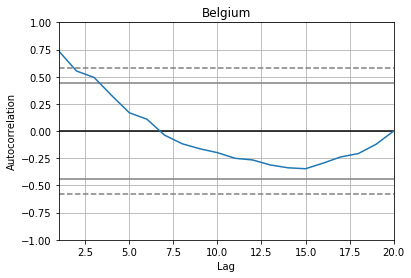

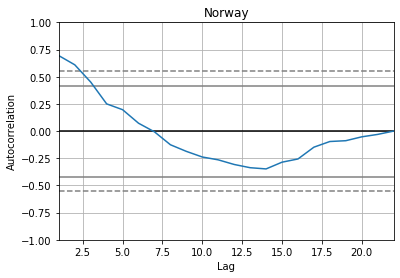

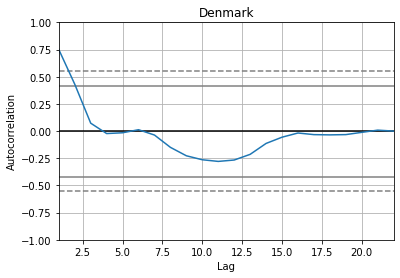

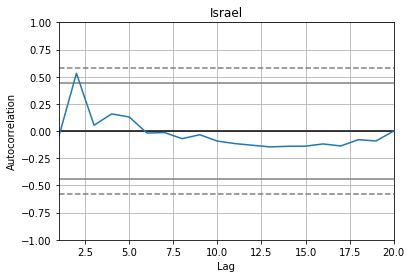

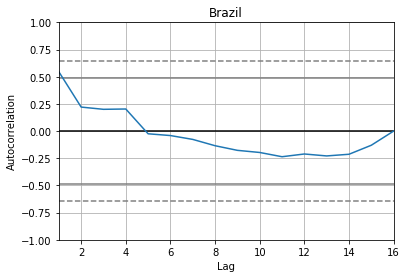

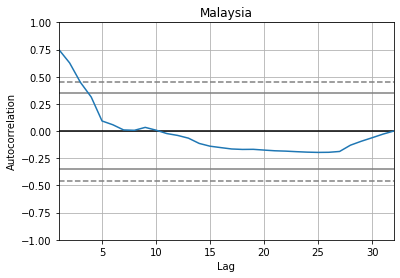

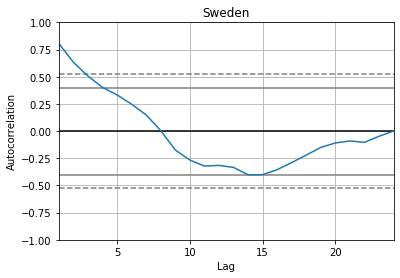

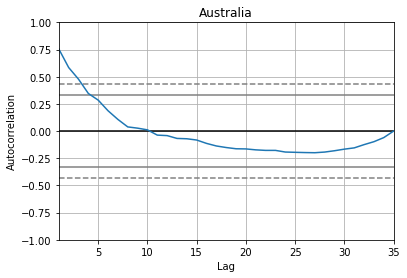

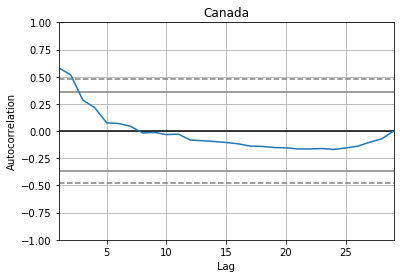

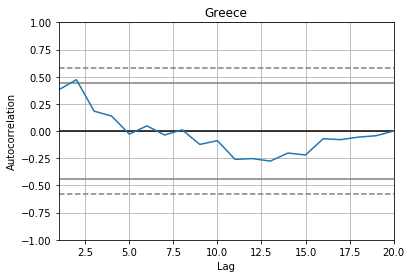

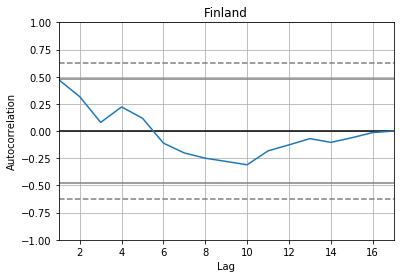

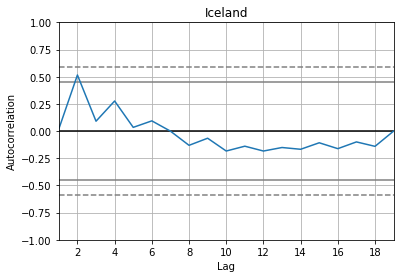

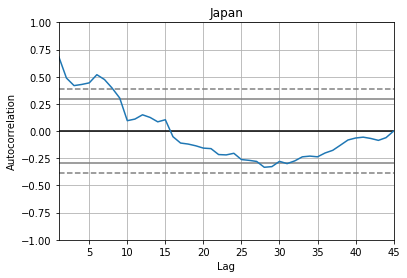

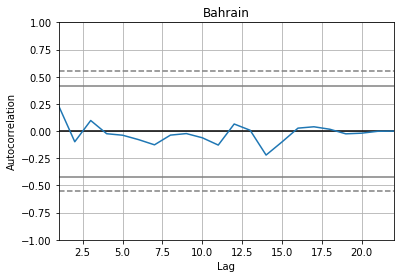

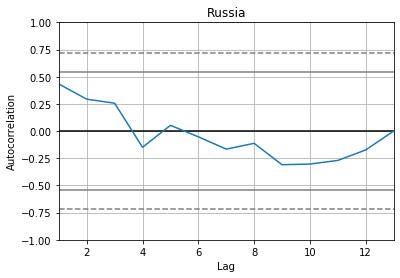

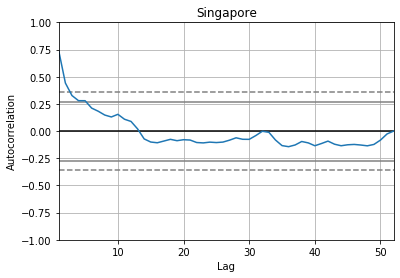

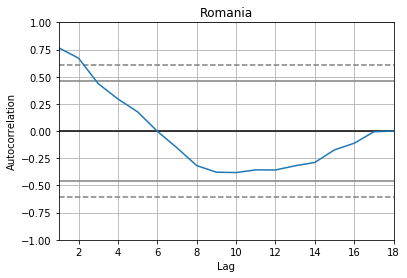

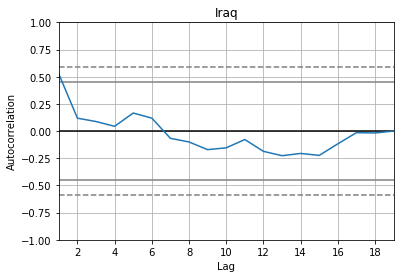

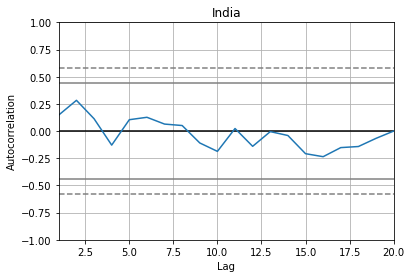

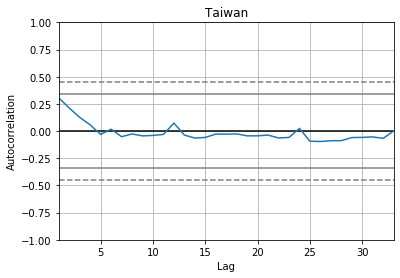

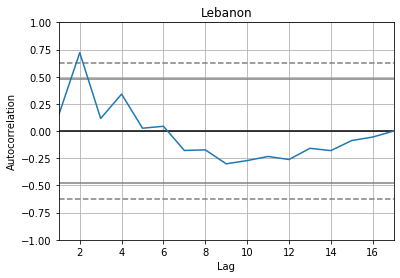

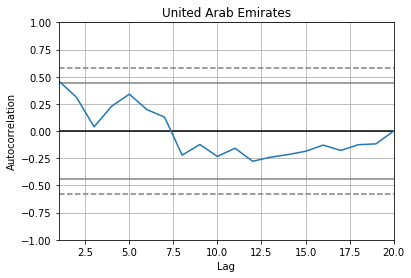

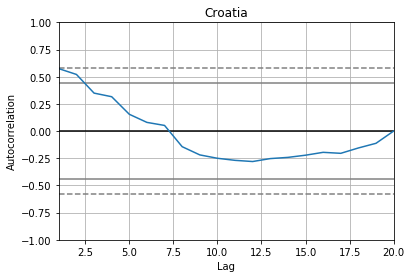

In [8]:
# plot autocorrelation for number of lags in time-series
if run_autocorrelation:
    for country in countries:
        autocorrelation_plot(covid19[country])
        plt.title(country)
        plt.show()

In [9]:
# looks like between ~(1-10) lags are correlated (some countries can use more, most around 5)
# lets use ARIMA to get a baseline, an idea of how many lags should be used, any derivatives, and size of moving average

In [10]:
def root_mean_squared_error(test, predictions):
    if len(test) == len(predictions):
        error = 0.
        for i in range(len(test)):
            error += (test[i] - predictions[i]) ** 2
        error /= float(len(test))
        return sqrt(error)
    
def root_mean_squared_percent_error(test, predictions):
    if len(test) == len(predictions):
        error = 0.
        for i in range(len(test)):
            error += ((test[i] - predictions[i]) / test[i]) ** 2
        error /= float(len(test))
        return 100 * sqrt(error)

In [11]:
# ARIMA testing over a range of lags, derivatives, and moving average days
header = ['Lags', 'Derv', 'Days', 'RMSE %', 'RMSE', '% Converged', 'Exec Time (s)']
if run_ARIMA:
    warnings.filterwarnings('ignore')
    rmspe = {}
    rmse = {}
    params = {}
    allTests = {}
    allPredictions = {}
    rmspe['all'] = []
    rmse['all'] = []
    params['all'] = []
    allTests['all'] = []
    allPredictions['all'] = []
    table = []
    times = []
    nIters = 1
    timer = Timer()
    for nDays in range(0, 8, 1):
        for derivative in range(0, 2, 1):
            for lag in range(nDays + 1, nDays + 8, 1):
                theseTests = []
                thesePredictions = []
                nConverged = 0
                nTried = 0
                for country in countries:
                    X = covid19[country]
                    if len(X) <= lag:
                        continue
                    size = 1 + lag + derivative
                    train, test = X[0:size], X[size:len(X)]
                    test_conv = []
                    history = [x for x in train]
                    predictions = list()
                    nSuccess = len(test)
                    for t in range(len(test)):
                        nTried += 1
                        try:
                            hist_temp = history
                            history.append(test[t])
                            model = ARIMA(hist_temp, order=(lag, derivative, nDays))
                            model_fit = model.fit(maxiter=1000)
                            output = model_fit.forecast()
                            test_conv.append(test[t])
                            predictions.append(output[0])
                        except Exception as e:
                            nSuccess -= 1
                    if nSuccess > 0:
                        nConverged += nSuccess
                        theseTests = theseTests + test_conv
                        thesePredictions = thesePredictions + predictions
                        error1 = root_mean_squared_error(test_conv, predictions)
                        error2 = root_mean_squared_percent_error(test_conv, predictions)
                        info = f'{country} rmse={error1:.2f} rmspe={error2:.2f}'
                        #print(info)

                        if country not in rmse:
                            rmse[country] = []
                            rmspe[country] = []
                            params[country] = []
                            allTests[country] = []
                            allPredictions[country] = []
                        rmse[country].append(error1)
                        rmspe[country].append(error2)
                        params[country].append([lag,derivative,nDays])
                        allTests[country].append(test_conv)
                        allPredictions[country].append(predictions)

                # log results
                this_time = timer.get_new_time()
                times.append(this_time)
                if nConverged > 0:
                    error1 = root_mean_squared_error(theseTests, thesePredictions)
                    error2 = root_mean_squared_percent_error(theseTests, thesePredictions)
                    params['all'].append([lag,derivative,nDays])
                    allTests['all'].append(theseTests)
                    allPredictions['all'].append(thesePredictions)
                    rmse['all'].append(error1)
                    rmspe['all'].append(error2)
                    table.append([ lag, derivative, nDays, round(error2, 2), round(error1, 2)
                                  , round(100 * nConverged / nTried, 2), this_time ])
                    clear_output()
                    print(tabulate(table, headers=header))
                print(f'estimated time left = {((64-nIters) * sum(times) / len(times) / 60):.2f} minutes')
                nIters += 1
    
    #write pickle file
    ARIMA_results = [rmspe,rmse,params,allTests,allPredictions,table]
    with open(output_ARIMA, 'wb') as outfile:
        pickle.dump(ARIMA_results, outfile)

In [12]:
# read pickle files (from previous ran ARIMAs)
ARIMA_results = {}
if read_ARIMA_results:
    for arima in input_ARIMA:
        with open(arima, 'rb' ) as infile:
            ARIMA_results[arima] = pickle.load(infile)
            print(tabulate(ARIMA_results[arima][-1], headers=header))

  Lags    Derv    Days    RMSE %      RMSE    % Converged    Exec Time (s)
------  ------  ------  --------  --------  -------------  ---------------
     1       0       0    310.89    212.1           97.39          41.6357
     2       0       0    259.17    592.11          91.27          83.7639
     3       0       0    270.63    405.47          81.3          137.791
     4       0       0    259.55   1303.2           61.14         162.8
     5       0       0    267.84    593.19          49.68         231.219
     6       0       0    262.77    985.45          38.56         276.92
     7       0       0    327.78   1015.42          29.7          436.478
     2       0       1  20135.7    7857.26          25.62          39.1062
     3       0       1    299.75    981.6           20.59          48.201
     4       0       1    302.97    620.75          21.04          75.3245
     5       0       1    321.75   1126.41          19.33         100.52
     6       0       1    373.69    

In [13]:
# from the two tables I chose the cases which have the best RMSE and convergence, one one with a good balance betwen both
# A) 12 lags, 1 derivative, 6 day moving window >>>> 34.91% RMSE, 3 cases RMSE, 1.05% datapoints convergence
# B) 1 lag, 1 derivative, 0 day moving window >>>> 172.23% RMSE, 591 cases RMSE, 98.53% datapoints convergence 
# C) 4 lag, 0 derivative, 2 day moving window >>>> 75.66% RMSE, 73 cases RMSE, 10.89% datapoitns convergence

# Prepare Data for Machine Learning

In [14]:
# takes the moving sum of data
# @data is pandas data frame split by ('Day', 'Cases', 'Country') 
    # assumed to be grouped by country name and sorted by day number in ascending order
# @days_moving is window size of moving sum
# returns dataFrame similar to @data except days are moving sums of those days 
    # there will be days_moving-1 less rows for each country
def movingSum(data, days_moving):
    # helper
    def addTo(window, idx, val):
        idx += 1
        if idx >= days_moving:
            idx = 0
        window[idx] = val
        return window, idx
        
    # take moving sum
    newRows = []
    lastCountry = ''
    counter = 0
    idx = 0
    window = [None] * days_moving
    for i in range(len(data)):
        country = str(data.at[i, 'Country'])
        if country not in lastCountry:
            counter = 0
        window, idx = addTo(window, idx, data.at[i, 'Cases'])
        counter += 1
        if counter >= days_moving:
            newRows.append([counter - days_moving, sum(window), country])
        lastCountry = country
    data2 = pd.DataFrame(newRows, columns=['Day', 'Cases', 'Country'])
    return data2

In [15]:
datas = {}

Xs = {} # fill chunks of feature vectors
Ys_class = {} # fill with labels of if next day will be higher or lower
Ys_regress = {} # fill with labels of value of next day
linked_countries = {} # fill with corresponding index of country used for data chunk 
linked_days = {} # fill with corresponding index of label number

Xs_train = {} # fill chunks of feature vectors
Ys_class_train = {} # fill with labels of if next day will be higher or lower
Ys_regress_train = {} # fill with labels of value of next day
linked_countries_train = {} # fill with corresponding index of country used for data chunk 
linked_days_train = {} # fill with corresponding index of label number

Xs_test = {} # fill chunks of feature vectors
Ys_class_test = {} # fill with labels of if next day will be higher or lower
Ys_regress_test = {} # fill with labels of value of next day
linked_countries_test = {} # fill with corresponding index of country used for data chunk 
linked_days_test = {} # fill with corresponding index of label number

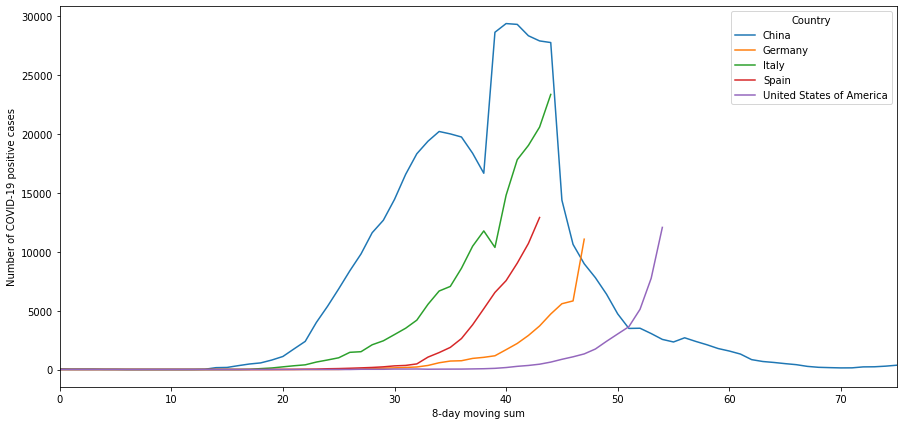

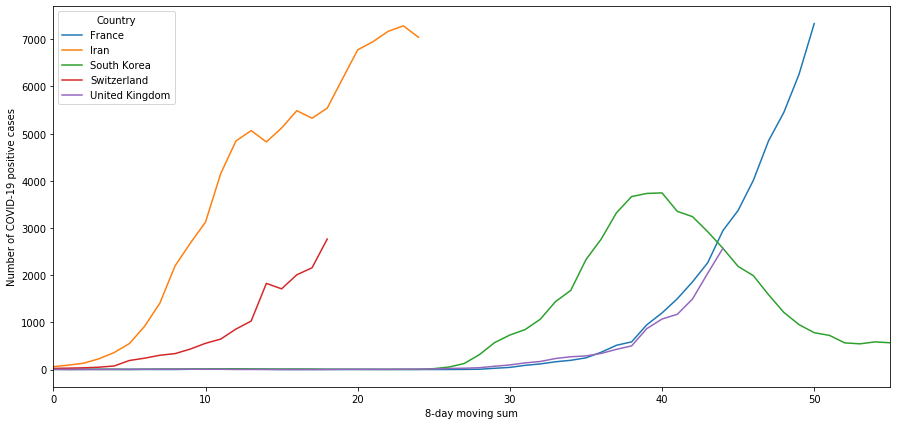

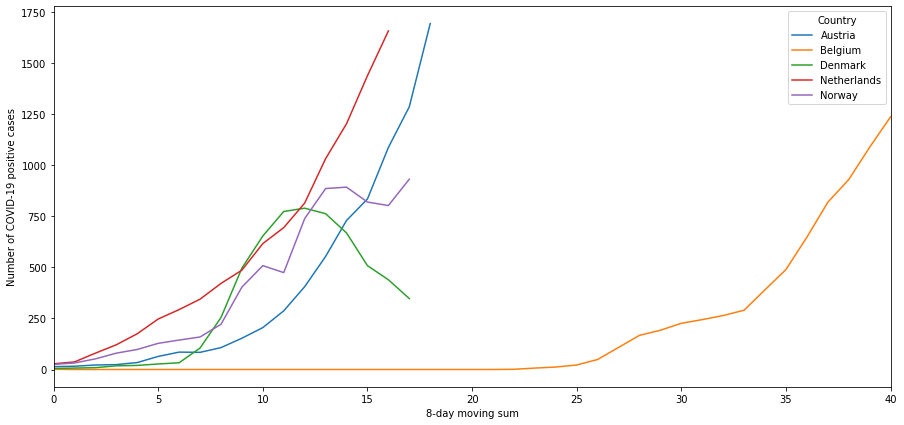

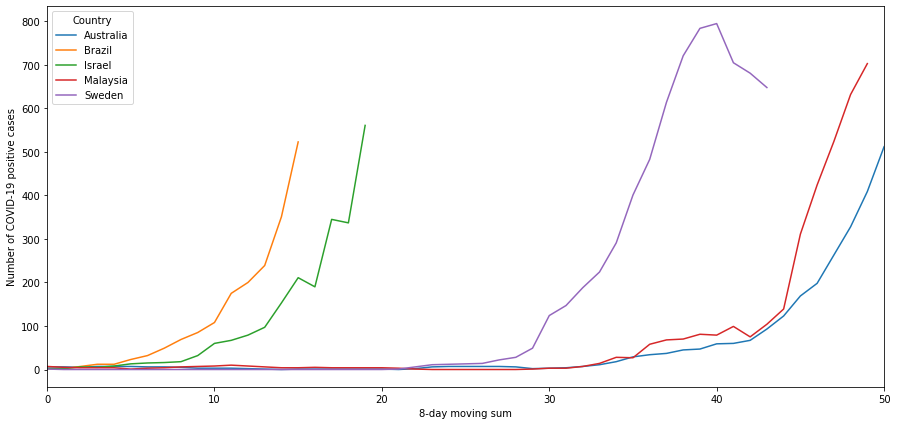

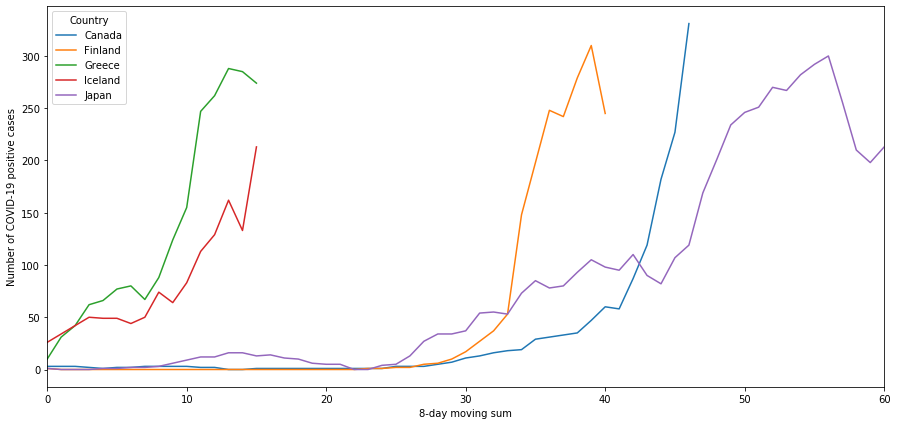

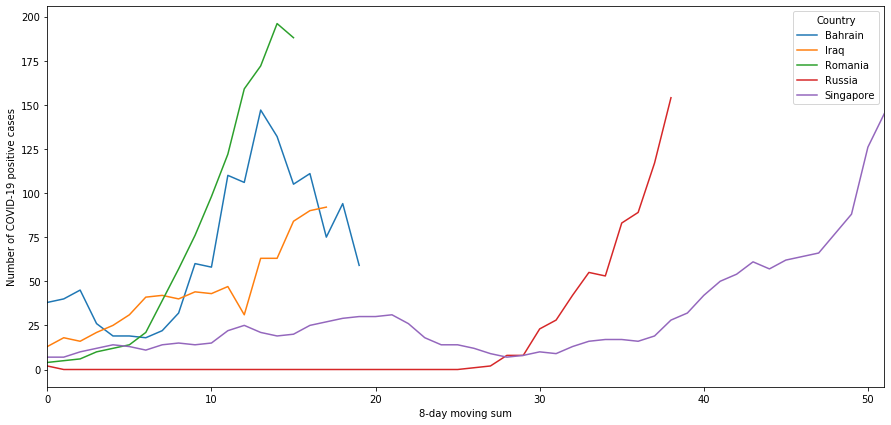

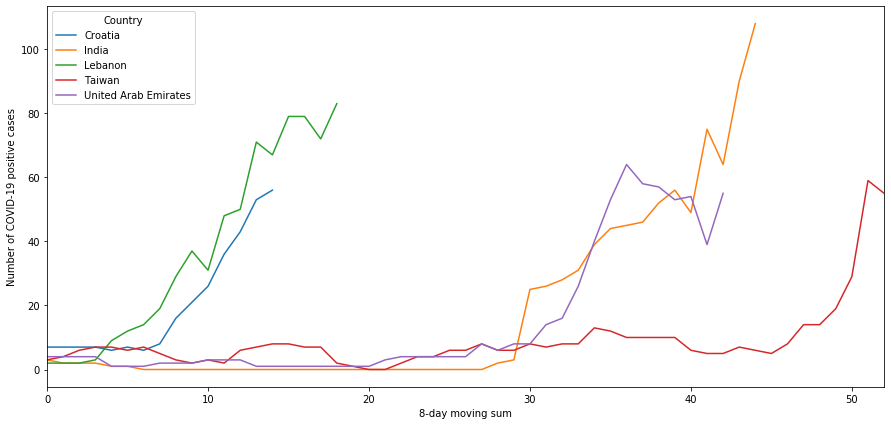

In [16]:
# map lags
lags = {'A' : 12, 'B' : 1, 'C' : 4}

# resample data
if resample:
    # make data for the 3 models which chose best RMSE, convergence, and balance between the two during the ARIMA search
    datas['A'] = movingSum(data, 6)
    datas['B'] = data
    datas['C'] = movingSum(data, 2)

    # map derivatives (this looks at change in cases rather than absolute number of cases)
    dervs = {'A' : True, 'B' : True, 'C' : False}

    # make chunks of data based on lag size for each feature vector, and next value (or derivative of next value) for label
    for model in datas:

        # grab data for this model
        this_data = datas[model]

        # create empty matrix to be filled with data chunks
        Xs[model] = [] # feature vectors
        Ys_class[model] = [] # class labels
        Ys_regress[model] = [] # regression labels
        linked_countries[model] = [] # country names
        linked_days[model] = [] # day numbers of label
        Xs_test[model] = [] # feature vectors
        Ys_class_test[model] = [] # class labels
        Ys_regress_test[model] = [] # regression labels
        linked_countries_test[model] = [] # country names
        linked_days_test[model] = [] # day numbers of label
        Xs_train[model] = [] # feature vectors
        Ys_class_train[model] = [] # class labels
        Ys_regress_train[model] = [] # regression labels
        linked_countries_train[model] = [] # country names
        linked_days_train[model] = [] # day numbers of label

        # move through all rows in data
        for i in range(len(this_data)):

            # get country for this row
            country = str(this_data.at[i, 'Country'])

            # make empty feature vector
            x = []

            # check out of bounds 
            if i + lags[model] >= len(this_data):
                break

            # get number of lags
            for j in range(i, i + lags[model], 1):

                # check if not the same country
                if this_data.at[j, 'Country'] not in country:
                    break

                # add cases to data chunk
                x.append(this_data.at[j, 'Cases'])

            # get label
            y_class = -1
            y_regress = -1
            day = -1
            if this_data.at[i + lags[model], 'Country'] in country:
                y_regress = int(this_data.at[i + lags[model], 'Cases'])
                if dervs[model]:
                    y_regress = int(this_data.at[i + lags[model], 'Cases']) - int(this_data.at[i + lags[model] - 1, 'Cases'])
                y_class = 1 if int(this_data.at[i+lags[model], 'Cases']) > int(this_data.at[i+lags[model]-1, 'Cases']) else 0
                day = int(this_data.at[i + lags[model], 'Day'])

            # add to matrix if feature vector is right size and label is valid
            if len(x) == lags[model] and y_regress > -1:
                Xs[model].append(x)
                Ys_regress[model].append(y_regress)
                Ys_class[model].append(y_class)
                linked_countries[model].append(country)
                linked_days[model].append(day)

                # add to train or test
                if random.random() > test_split:
                    Xs_test[model].append(x)
                    Ys_regress_test[model].append(y_regress)
                    Ys_class_test[model].append(y_class)
                    linked_countries_test[model].append(country)
                    linked_days_test[model].append(day)
                else:
                    Xs_train[model].append(x)
                    Ys_regress_train[model].append(y_regress)
                    Ys_class_train[model].append(y_class)
                    linked_countries_train[model].append(country)
                    linked_days_train[model].append(day)


    #write pickle files
    pickle_out = [datas
                  ,Xs,Ys_class,Ys_regress,linked_countries,linked_days
                 ,Xs_train,Ys_class_train,Ys_regress_train,linked_countries_train,linked_days_train
                 ,Xs_test,Ys_class_test,Ys_regress_test,linked_countries_test,linked_days_test]
    with open(output_sample, 'wb') as outfile:
        pickle.dump(pickle_out, outfile)
else:
    # read pickle files (from previous sampling)
    with open(input_sample, 'rb' ) as infile:
        pickle_in = pickle.load(infile)

        idx = 0
        datas = pickle_in[idx]

        idx += 1
        Xs = pickle_in[idx]
        idx += 1
        Ys_class = pickle_in[idx]
        idx += 1
        Ys_regress = pickle_in[idx]
        idx += 1
        linked_countries = pickle_in[idx]
        idx += 1
        linked_days = pickle_in[idx]
        idx += 1

        Xs_train = pickle_in[idx]
        idx += 1
        Ys_class_train = pickle_in[idx]
        idx += 1
        Ys_regress_train = pickle_in[idx]
        idx += 1
        linked_countries_train = pickle_in[idx]
        idx += 1
        linked_days_train = pickle_in[idx]
        idx += 1

        Xs_test = pickle_in[idx]
        idx += 1
        Ys_class_test = pickle_in[idx]
        idx += 1
        Ys_regress_test = pickle_in[idx]
        idx += 1
        linked_countries_test = pickle_in[idx]
        idx += 1
        linked_days_test = pickle_in[idx]
        idx += 1
    
# view the 8-day moving window (looks much much smoother now)
plot5(datas['A'], countries, '8-day moving sum', 'Number of COVID-19 positive cases')

# Cross-validate for model selection

In [17]:
def crossValidation_class(name, X, y, nIters, nFolds, layers):
    dis = display(f'running MLA {name}',display_id=True)
    
    # create dummy Machine Learning Algorithm (MLA) object
    mla = tree.DecisionTreeClassifier()
    
    # keep track of results
    means = [None] * nIters
    #stds = [None] * nIters
    
    # get results
    for i in range(nIters):
         # create MLA with new random seed
        if 'DT' in name:
            mla = DecisionTreeClassifier(random_state = i)
        elif 'NB' in name:
            mla = GaussianNB()
        elif 'RF' in name:
            mla = RandomForestClassifier(random_state = i, n_estimators=100)
        elif 'ET' in name:
            mla = ExtraTreesClassifier(random_state = i, n_estimators=100)
        elif 'SV' in name:
            mla = SVC(random_state = i, gamma='auto', probability=True)
        elif 'KN' in name:
            mla = KNeighborsClassifier(n_neighbors=2)
        elif 'ML' in name:
            mla = MLPClassifier(random_state = i, hidden_layer_sizes=layers, max_iter=10000)
            
        scores = cross_val_score(mla, X, y, cv=nFolds)
        means[i] = scores.mean()
        #stds[i] = std(scores)
        dis.update(f'iteration {i+1} of {nIters} done')
    dis.update(f'Average classification accuracy = {100. * sum(means) / len(means):.2f}%')
        
    return means

In [21]:
def plotResults_class(results, mlas, model):
    x_labels = []
    for mla in mlas:
        x_labels.append(mla)
        x_labels.append(' ')
        x_labels.append(' ')
        x_labels.append(' ')
    x_nums = [x for x in range(5*len(mlas))]
    fig = plt.figure(figsize=(7.5,5))
    plt.xticks(x_nums, x_labels, rotation='vertical', fontsize=20)
    plt.yticks([x for x in range(75, 101, 5)], fontsize=20)
    plt.tick_params(axis='x', length=0)
    plt.ylabel('% Classification Accuracy', fontsize=20)
    plt.title('10-Fold Cross-Validation Incrase or Decrease in Cases - Model ' + model, fontsize=20)
    plt.grid(axis='y', linewidth=0.4)
    plt.ylim([75, 101])
    offset = 0
    for mla in results:
        x = [offset for _ in range(len(results[mla]))]
        y = 100. * np.array(results[mla])
        if int(max(y)) <= 75:
            plt.scatter(offset+0, 76, color='green', marker='v')
        else:
            plt.scatter(x, y, color='green', marker='_', s=1000)
        plt.axvline(x=offset, color='grey', linewidth=0.3, alpha=0.3)
        offset += 4
    fig.text(0, -.20, 'Illustrates distribution of accuracies for each MLA.\nResults from 100 random runs.\nA down facing triangle indicates results below 75% accuracy'
             , fontsize=20)

In [19]:
# run classification results of checking if number of cases increases or decreases
class_results = {}
mlas = ['ML', 'DT', 'RF', 'ET', 'NB', 'SV', 'KN']
if run_class:
    for model in datas:
        class_results[model] = {}
        print('model ' + model + ' ...')
        for mla in mlas:
            print('MLA ' + mla + ' ...')
            class_results[model][mla] = crossValidation_class(mla, Xs_train[model], Ys_class_train[model], 100, 10
                                                              , (max(int(lags[model]/2), 1)) )

    #write pickle file with results
    with open(output_class, 'wb') as outfile:
        pickle.dump(class_results, outfile)

model A ...
MLA ML ...


'Average classification accuracy = 79.98%'

MLA DT ...


'Average classification accuracy = 86.39%'

MLA RF ...


'Average classification accuracy = 86.89%'

MLA ET ...


'Average classification accuracy = 85.69%'

MLA NB ...


'Average classification accuracy = 75.14%'

MLA SV ...


'Average classification accuracy = 84.70%'

MLA KN ...


'Average classification accuracy = 74.56%'

model B ...
MLA ML ...


'Average classification accuracy = 62.71%'

MLA DT ...


'Average classification accuracy = 74.06%'

MLA RF ...


'Average classification accuracy = 74.93%'

MLA ET ...


'Average classification accuracy = 74.06%'

MLA NB ...


'Average classification accuracy = 77.87%'

MLA SV ...


'Average classification accuracy = 75.54%'

MLA KN ...


'Average classification accuracy = 76.32%'

model C ...
MLA ML ...


'Average classification accuracy = 55.46%'

MLA DT ...


'Average classification accuracy = 66.48%'

MLA RF ...


'Average classification accuracy = 67.19%'

MLA ET ...


'Average classification accuracy = 65.98%'

MLA NB ...


'Average classification accuracy = 40.61%'

MLA SV ...


'Average classification accuracy = 67.20%'

MLA KN ...


'Average classification accuracy = 56.89%'

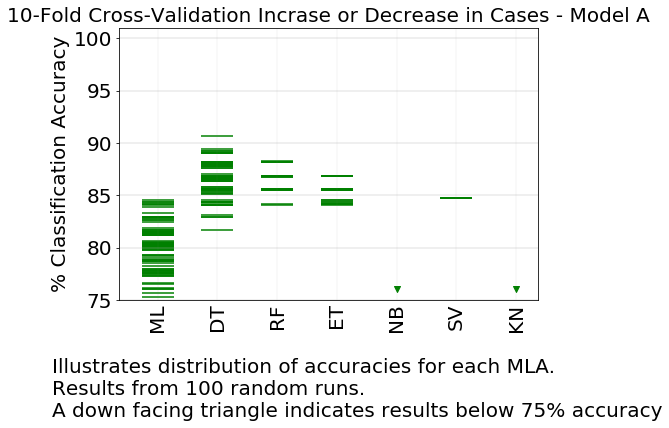

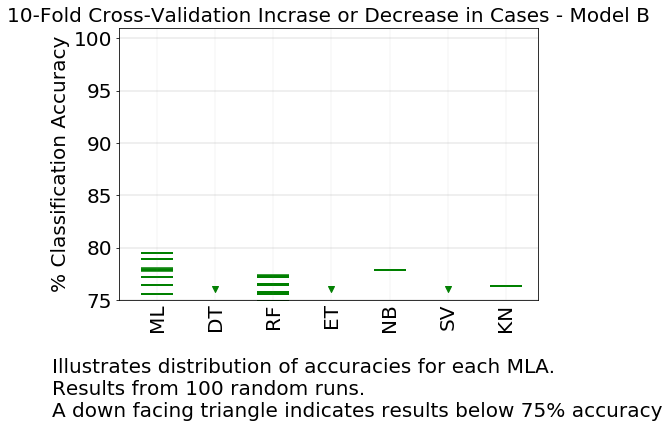

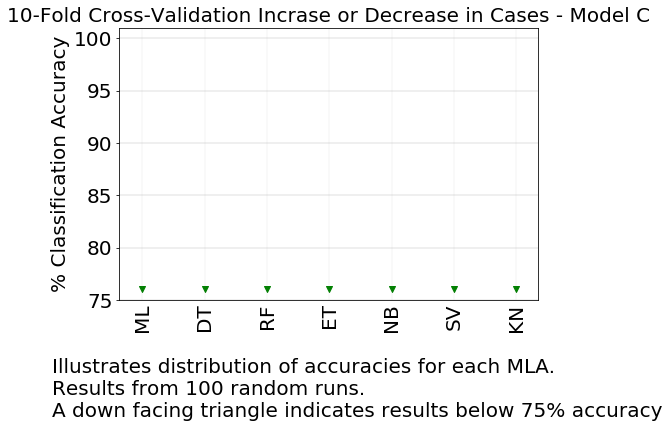

In [25]:
# plot results
class_results_read = {}
if read_class_results:
    for file in input_class:
        with open(file, 'rb' ) as infile:
            class_results_read[file] = pickle.load(infile)
            for model in class_results_read[file]:
                plotResults_class(class_results_read[file][model], mlas, model) 
else:
    for model in class_results:
        plotResults_class(class_results[model], mlas, model) 

In [28]:
# It is very clear from the above plots that model A is the most robust
    # Model A = 12 lags, 1 derivative, 6 day moving window
# The most robust MLA's were Decision Trees, Random Forests, Extra Trees, and Support Vector Machines
# I chose an SVM since they are indepedendent of randomness and performed on-par to the average classification of trees

# Machine Learning Algorithm Optimization

In [29]:
# So our final selection is Model A with an SVM
# the task left is to optimize the parameters of the SVM using a grid search and cross-validation

In [60]:
# optimize SVM params
warnings.filterwarnings('ignore')
parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'C':[1, 10, 100, 1000]
              , 'tol':[0.1, 0.01, 0.001, 0.0001], 'shrinking':[True, False]
             ,'coef0':[0,1,2,3], 'gamma' : ['auto', 'scale']}
svc = SVC(probability=True)
clf = GridSearchCV(svc, parameters)
clf.fit(Xs_train['A'], Ys_class_train['A'])
cv_results = clf.cv_results_['mean_test_score']
cv_params = clf.cv_results_['params']
max_acc = max(cv_results)
opt_results = []
opt_params = []
for i in range(len(cv_results)):
    if abs(cv_results[i]-max_acc) <= 0.01:
        opt_results.append(cv_results[i])
        opt_params.append(cv_params[i])
print('optimizied classification accuracy =', max_acc)
print('These parameters obtained optimized acc:')
for params in opt_params:
    print(params)

optimizied classification accuracy = 0.8533333333333334
These parameters obtained optimized acc:
{'C': 10, 'coef0': 0, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True, 'tol': 0.1}
{'C': 10, 'coef0': 0, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True, 'tol': 0.01}
{'C': 10, 'coef0': 0, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True, 'tol': 0.001}
{'C': 10, 'coef0': 0, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True, 'tol': 0.0001}
{'C': 10, 'coef0': 0, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': False, 'tol': 0.1}
{'C': 10, 'coef0': 0, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': False, 'tol': 0.01}
{'C': 10, 'coef0': 0, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': False, 'tol': 0.001}
{'C': 10, 'coef0': 0, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': False, 'tol': 0.0001}
{'C': 10, 'coef0': 1, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True, 'tol': 0.1}
{'C': 10, 'coef0': 1, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True, 'tol': 0.01}
{'C': 10, 'coef0

In [61]:
# kernel 'rbf' is the most robust, gamma 'auto' is the most robust, C 10-1000 are equally robust 
# coef0 makes no difference, shrkining makes no difference, tol makes no difference
# thus the final svm used kernel 'rbg', gamma 'auto', C 10, and default values for the rest
svc = SVC(kernel='rbf', gamma='auto', C=10, probability=True)

# Final Results

In [69]:
# now we train svs on data and test on the test data
svc.fit(Xs_train['A'], Ys_class_train['A'])
test_class = svc.predict(Xs_test['A'])
print(f'final test accuracy is:', round(100. * accuracy_score(test_class, Ys_class_test['A']), 2), '%')

final test accuracy is: 83.33 %
